# **Evaluación del modelo final y diseño de estrategias basadas en niveles de riesgo.**
Este notebook tiene como objetivo evaluar el rendimiento del modelo final seleccionado para la predicción de supervivencia, aplicando un **umbral personalizado de decisión** y desarrollando una **estrategia de clasificación por niveles de riesgo clínicamente interpretables**.

A lo largo del notebook se realiza:

- La inferencia del modelo sobre el conjunto de test.
- El análisis de métricas con el umbral calibrado.
- La asignación de niveles de riesgo basados en la probabilidad de no supervivencia.
- La propuesta de acciones clínicas recomendadas para cada nivel de riesgo.
- Una visualización clara de la distribución de pacientes por riesgo.

Este enfoque permite transformar la predicción binaria clásica en una herramienta más flexible y útil para la toma de decisiones médicas adaptadas al contexto clínico.

## **Importación de librerías.**
Se cargan las librerías necesarias (incluidas en el archivo `requirements.txt`) para trabajar con manipulación de datos y archivos.

In [115]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import load_model
import json
from sklearn.metrics import confusion_matrix, classification_report
from tabulate import tabulate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
import shap

greens = plt.get_cmap('Greens')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## **Importación e información de Dataframes.**

In [2]:
df = pd.read_csv('../data/processed/MONGO00_All_v1.csv', index_col=0)
df.head()

,glucosa,colesterol,trigliceridos,hemoglobina,leucocitos,plaquetas,creatinina,diabetes,hipertension,obesidad,cancer,enfermedad_cardiaca,epoc,mut_BRCA1,mut_TP53,mut_EGFR,mut_KRAS,mut_PIK3CA,mut_ALK,mut_BRAF,ingresos_mensuales,gastos_salud,deudas,fumador,actividad_fisica,vive,edad,sexo,nivel_educativo,tipo_empleo_Desempleado,tipo_empleo_Privado,tipo_empleo_Público,tipo_empleo_Temporal,estado_civil_Divorciado,estado_civil_Soltero,estado_civil_Viudo,ocupacion_Desempleado,ocupacion_Empleado,ocupacion_Jubilado,region_Este,region_Norte,region_Oeste,region_Sur,continente_nacimiento_Antarctica,continente_nacimiento_Asia,continente_nacimiento_Europe,continente_nacimiento_North America,continente_nacimiento_Oceania,continente_nacimiento_South America
paciente_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
P1000000,1.125931,1.116180,0.518919,-0.262543,-0.924342,0.202956,-0.323535,1,1,1,0,1,0,0,0,0,0,0,0,1,1.499543,2.487493,0,1,-1.039961,1,0.750106,0,-0.44961,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
P1000001,-1.549388,-1.768373,-1.357231,0.177002,-0.083060,0.709850,-0.883740,0,0,0,0,0,0,0,0,0,0,0,0,1,2.557298,-0.885562,0,0,0.344623,0,-1.028843,1,0.44846,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
P1000002,-0.436864,-0.699218,-2.059947,-0.742047,0.481094,-0.116266,2.570857,0,0,0,0,0,1,0,0,0,0,0,0,0,1.082786,-0.885562,0,1,-1.039961,1,1.711700,1,-1.34768,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0
P1000003,-0.258148,0.287809,-0.946194,-0.552243,1.490633,-0.122279,1.030293,1,0,1,1,1,0,0,0,0,1,0,0,0,-0.009775,2.487493,0,1,-1.039961,0,1.182823,1,-0.44961,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
P1000004,-1.940861,-1.565293,-2.566843,-1.161613,1.134325,-0.389633,-0.743689,0,0,0,0,0,0,0,0,0,0,0,0,0,0.011400,-0.885562,0,1,0.344623,1,-0.740365,0,1.34653,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [3]:
df.shape

(50000, 49)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, P1000000 to P1049999
Data columns (total 49 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   glucosa                              50000 non-null  float64
 1   colesterol                           50000 non-null  float64
 2   trigliceridos                        50000 non-null  float64
 3   hemoglobina                          50000 non-null  float64
 4   leucocitos                           50000 non-null  float64
 5   plaquetas                            50000 non-null  float64
 6   creatinina                           50000 non-null  float64
 7   diabetes                             50000 non-null  int64  
 8   hipertension                         50000 non-null  int64  
 9   obesidad                             50000 non-null  int64  
 10  cancer                               50000 non-null  int64  
 11  enfermedad_cardiaca    

In [5]:
df.columns

Index(['glucosa', 'colesterol', 'trigliceridos', 'hemoglobina', 'leucocitos', 'plaquetas', 'creatinina', 'diabetes', 'hipertension', 'obesidad', 'cancer', 'enfermedad_cardiaca', 'epoc', 'mut_BRCA1', 'mut_TP53', 'mut_EGFR', 'mut_KRAS', 'mut_PIK3CA', 'mut_ALK', 'mut_BRAF', 'ingresos_mensuales', 'gastos_salud', 'deudas', 'fumador', 'actividad_fisica', 'vive', 'edad', 'sexo', 'nivel_educativo', 'tipo_empleo_Desempleado', 'tipo_empleo_Privado', 'tipo_empleo_Público', 'tipo_empleo_Temporal', 'estado_civil_Divorciado', 'estado_civil_Soltero', 'estado_civil_Viudo', 'ocupacion_Desempleado', 'ocupacion_Empleado', 'ocupacion_Jubilado', 'region_Este', 'region_Norte', 'region_Oeste', 'region_Sur', 'continente_nacimiento_Antarctica', 'continente_nacimiento_Asia', 'continente_nacimiento_Europe', 'continente_nacimiento_North America', 'continente_nacimiento_Oceania', 'continente_nacimiento_South America'], dtype='object')

El presente modelo de red neuronal tiene como objetivo **predecir la probabilidad de supervivencia** de un paciente (`vive = 1`) en base a un conjunto heterogéneo de variables clínicas, genéticas, socioeconómicas y demográficas. Cada grupo de variables aporta información complementaria que puede ser determinante para identificar patrones de riesgo. A continuación se describe el propósito específico de cada conjunto de variables dentro del modelo:
1. **Variables bioquímicas:** Estas variables reflejan el estado fisiológico y metabólico del paciente en el momento del análisis. Son esenciales para evaluar alteraciones funcionales que pueden estar asociadas a condiciones críticas.
    - `glucosa`, `colesterol`, `trigliceridos`: indicadores metabólicos relacionados con riesgo cardiovascular y complicaciones sistémicas.
    - `hemoglobina`, `leucocitos`, `plaquetas`: marcadores hematológicos clave para detectar anemia, infecciones o problemas inmunológicos.
    - `creatinina`: medida de función renal, importante en pacientes crónicos o polimedicados.

    Estas variables deben ser tratadas como **predictoras continuas**, y **normalizadas** antes de introducirse en la red.

2. **Variables clínicas:** Incluyen antecedentes y diagnósticos médicos relevantes, que afectan directamente al pronóstico del paciente.
    - `diabetes`, `hipertension`, `obesidad`, `cancer`, `enfermedad_cardiaca`, `asma`, `epoc`: condiciones clínicas codificadas como binarias (presente/no presente), que influyen significativamente en el riesgo de mortalidad.

    Estas variables actuarán como **factores de riesgo explícitos**, directamente introducibles en el modelo como **variables categóricas binarias**.

3. **Variables genéticas:** Representan la presencia de mutaciones en genes asociados a riesgo oncológico o enfermedades crónicas.
    - `mut_BRCA1`, `mut_TP53`, `mut_EGFR`, `mut_KRAS`, `mut_PIK3CA`, `mut_ALK`, `mut_BRAF`: presencia/ausencia de mutaciones genéticas, todas de tipo binario.

    Se usarán como **indicadores moleculares de susceptibilidad o agresividad clínica**.

4. **Variables socioeconómicas:** Estas variables permiten modelar el **contexto económico del paciente**, lo cual puede condicionar el acceso a cuidados, adherencia al tratamiento o exposición a factores de riesgo.
    - `ingresos_mensuales`: nivel de ingresos del hogar (requiere limpieza y transformación numérica).
    - `gastos_salud`, `deudas`: nivel de carga económica en salud o endeudamiento.
    - `seguro_salud`, `ayudas_publicas`: cobertura de necesidades básicas y acceso a servicios.
    - `tipo_empleo`: nivel de estabilidad laboral o exposición laboral (requiere codificación categórica).

    Estas variables se utilizarán para enriquecer el modelo con información **social y financiera**, relevante en medicina personalizada.

5. **Variables de estilo de vida:** Influyen directamente en el pronóstico, ya que reflejan **conductas de riesgo o factores protectores**.
    - `fumador`, `alcohol`: consumo de sustancias nocivas.
    - `actividad_fisica`: nivel de movilidad o ejercicio, que puede tener un efecto protector.

    Estas variables se integrarán como **predictoras categóricas discretas**, especialmente útiles para ajustar perfiles de riesgo.

6. **Variable objetivo**
    - `vive`: variable binaria que indica si el paciente ha sobrevivido tras un periodo crítico. Esta es la **variable objetivo del modelo** y se utilizará para entrenamiento supervisado.

7. **Variables demográficas y contexto:** Estas variables permiten contextualizar al paciente dentro de su entorno social y cultural, lo que puede afectar directa o indirectamente a su salud.
    - `edad`: variable continua de alta relevancia clínica.
    - `sexo`, `estado_civil`, `nivel_educativo`, `ocupacion`, `region`, `pais_nacimiento`, `codigo_postal`: variables categóricas con posible relación con factores estructurales de salud y mortalidad.

    Se incorporarán al modelo con el objetivo de **detectar patrones diferenciales por perfil poblacional**.



In [6]:
df.head(3)

,glucosa,colesterol,trigliceridos,hemoglobina,leucocitos,plaquetas,creatinina,diabetes,hipertension,obesidad,cancer,enfermedad_cardiaca,epoc,mut_BRCA1,mut_TP53,mut_EGFR,mut_KRAS,mut_PIK3CA,mut_ALK,mut_BRAF,ingresos_mensuales,gastos_salud,deudas,fumador,actividad_fisica,vive,edad,sexo,nivel_educativo,tipo_empleo_Desempleado,tipo_empleo_Privado,tipo_empleo_Público,tipo_empleo_Temporal,estado_civil_Divorciado,estado_civil_Soltero,estado_civil_Viudo,ocupacion_Desempleado,ocupacion_Empleado,ocupacion_Jubilado,region_Este,region_Norte,region_Oeste,region_Sur,continente_nacimiento_Antarctica,continente_nacimiento_Asia,continente_nacimiento_Europe,continente_nacimiento_North America,continente_nacimiento_Oceania,continente_nacimiento_South America
paciente_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
P1000000,1.125931,1.116180,0.518919,-0.262543,-0.924342,0.202956,-0.323535,1,1,1,0,1,0,0,0,0,0,0,0,1,1.499543,2.487493,0,1,-1.039961,1,0.750106,0,-0.44961,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
P1000001,-1.549388,-1.768373,-1.357231,0.177002,-0.083060,0.709850,-0.883740,0,0,0,0,0,0,0,0,0,0,0,0,1,2.557298,-0.885562,0,0,0.344623,0,-1.028843,1,0.44846,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
P1000002,-0.436864,-0.699218,-2.059947,-0.742047,0.481094,-0.116266,2.570857,0,0,0,0,0,1,0,0,0,0,0,0,0,1.082786,-0.885562,0,1,-1.039961,1,1.711700,1,-1.34768,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0


## **Selección de modelo.**
Se cargan tanto el conjunto de datos de test previamente procesado (X_test_red, y_test), como los modelos seleccionados para elegir uno de estos.

In [30]:
# Carga de modelos.
model_rus = load_model('../models/rus_model_v3.keras')
model_cw = load_model('../models/cw_model_v1.keras')

In [31]:
with open('../models/cw_historial_v1.json', 'r') as f:
    history_cw = json.load(f)

with open('../models/rus_historial_v3.json', 'r') as f:
    history_rus = json.load(f)

In [32]:
# Carga de las columnas seleccionadas.
with open("../benchmarking/top_features.json", "r") as f:
    top_features = json.load(f)
print('Columnas seleccionadas:')
print(top_features)

Columnas seleccionadas:
['cancer', 'gastos_salud', 'glucosa', 'leucocitos', 'trigliceridos', 'colesterol', 'enfermedad_cardiaca', 'hemoglobina', 'plaquetas', 'ingresos_mensuales', 'creatinina', 'edad', 'nivel_educativo', 'sexo', 'actividad_fisica']


In [33]:
X = df.drop(columns='vive')
y = df['vive']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [35]:
# Filtramos los conjuntos de datos.
X_train_red = X_train[top_features]
X_test_red = X_test[top_features]

In [37]:
y_pred_proba_rus = model_rus.predict(X_test_red).ravel()
y_pred_proba_cw = model_cw.predict(X_test_red).ravel()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step


In [64]:
# RUS Model.
threshold = 0.65
y_pred = (y_pred_proba_rus > threshold).astype(int)
cm_rus = confusion_matrix(y_test, y_pred)
num_classes = cm_rus.shape[0]
print('Modelo RUS:\n')
print(tabulate(
        cm_rus,
        headers=[f'Pred Class {i}' for i in range(num_classes)],
        showindex=[f'Real Class {i}' for i in range(num_classes)],
        tablefmt="fancy_grid"
    ))
print(classification_report(y_test, y_pred, digits=4))


Modelo RUS:

╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │            893 │            390 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │           2236 │           6481 │
╘══════════════╧════════════════╧════════════════╛
              precision    recall  f1-score   support

           0     0.2854    0.6960    0.4048      1283
           1     0.9432    0.7435    0.8315      8717

    accuracy                         0.7374     10000
   macro avg     0.6143    0.7198    0.6182     10000
weighted avg     0.8588    0.7374    0.7768     10000



In [65]:
# CW Model.
threshold = 0.6
y_pred = (y_pred_proba_cw > threshold).astype(int)
cm_cw = confusion_matrix(y_test, y_pred)
num_classes = cm_cw.shape[0]
print('Modelo CW:\n')
print(tabulate(
        cm_cw,
        headers=[f'Pred Class {i}' for i in range(num_classes)],
        showindex=[f'Real Class {i}' for i in range(num_classes)],
        tablefmt="fancy_grid"
    ))
print(classification_report(y_test, y_pred, digits=4))

Modelo CW:

╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │            886 │            397 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │           2047 │           6670 │
╘══════════════╧════════════════╧════════════════╛
              precision    recall  f1-score   support

           0     0.3021    0.6906    0.4203      1283
           1     0.9438    0.7652    0.8452      8717

    accuracy                         0.7556     10000
   macro avg     0.6230    0.7279    0.6327     10000
weighted avg     0.8615    0.7556    0.7907     10000



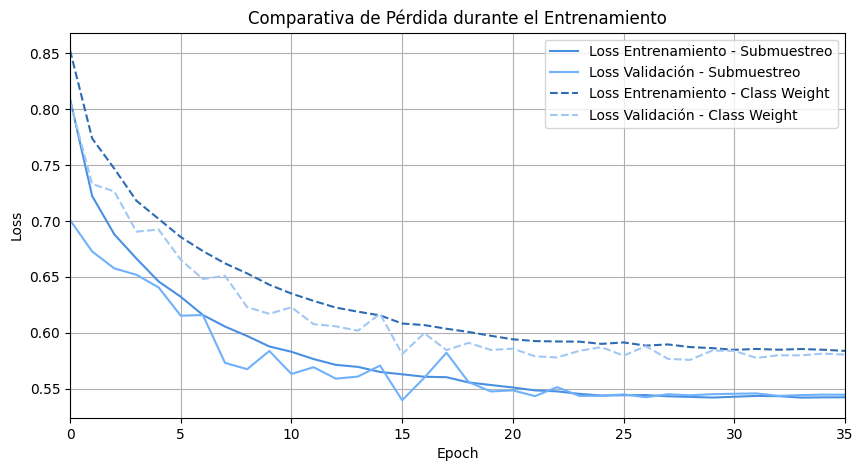

In [122]:
plt.figure(figsize=(10, 5))
plt.plot(history_rus['loss'], label='Loss Entrenamiento - Submuestreo', color = '#4A90E2')
plt.plot(history_rus['val_loss'], label='Loss Validación - Submuestreo', color = '#6FB1FC')
plt.plot(history_cw['loss'], label='Loss Entrenamiento - Class Weight', linestyle='--', color = '#2D6BB3')
plt.plot(history_cw['val_loss'], label='Loss Validación - Class Weight', linestyle='--', color = '#A0C8F5')
plt.title('Comparativa de Pérdida durante el Entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xlim(0, 35)
plt.grid(True)
plt.show()

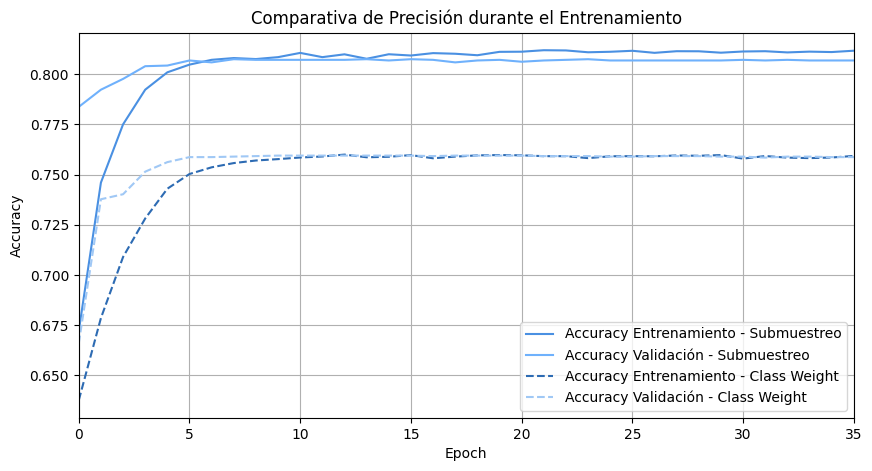

In [123]:
plt.figure(figsize=(10, 5))
plt.plot(history_rus['accuracy'], label='Accuracy Entrenamiento - Submuestreo', color = '#4A90E2')
plt.plot(history_rus['val_accuracy'], label='Accuracy Validación - Submuestreo', color = '#6FB1FC')
plt.plot(history_cw['accuracy'], label='Accuracy Entrenamiento - Class Weight', linestyle='--', color = '#2D6BB3')
plt.plot(history_cw['val_accuracy'], label='Accuracy Validación - Class Weight', linestyle='--', color = '#A0C8F5')
plt.title('Comparativa de Precisión durante el Entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.xlim(0, 35)
plt.grid(True)
plt.show()

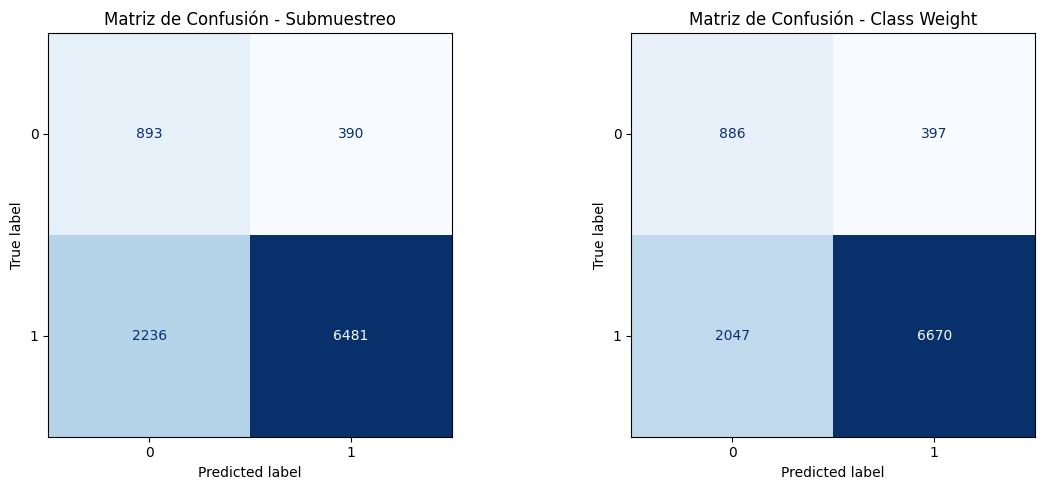

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz 1: Submuestreo
disp_rus = ConfusionMatrixDisplay(confusion_matrix=cm_rus)
disp_rus.plot(ax=axes[0], values_format='d', cmap='Blues', colorbar=False)
axes[0].set_title('Matriz de Confusión - Submuestreo')

# Matriz 2: Class Weight
disp_cw = ConfusionMatrixDisplay(confusion_matrix=cm_cw)
disp_cw.plot(ax=axes[1], values_format='d', cmap='Blues', colorbar=False)
axes[1].set_title('Matriz de Confusión - Class Weight')

plt.tight_layout()
plt.show()

Tras analizar los resultados de los modelos basados en `class_weight` y en `NeighbourhoodCleaningRule + class_weight`, la decisión se ha inclinado hacia el primero debido a su **mayor estabilidad visual y mejor comportamiento generalizado**, incluso si la diferencia en métricas es marginal.

A continuación, se compara el comportamiento visual de ambos modelos en cuanto a pérdida y precisión:

**Curvas de Pérdida (Loss).**

| Métrica                      | Submuestreo (RUS + CW)               | Solo `class_weight`                  | Ganador Visual   |
| ---------------------------- | ------------------------------------ | ------------------------------------ | ---------------- |
| **Tendencia global**         | Decreciente, pero con altibajos      | Decreciente y constante              | `class_weight` |
| **Estabilidad de val\_loss** | Fluctúa visiblemente entre épocas    | Muy estable, sin saltos abruptos     | `class_weight` |
| **Cercanía entre curvas**    | Relativamente próxima                | Aún más próxima y paralela           | `class_weight`  |
| **Ruido visual**             | Moderado, especialmente en val\_loss | Mínimo ruido a partir de la época 10 | `class_weight` |

**Curvas de Precisión (Accuracy)**

| Métrica                       | Submuestreo (RUS + CW)           | Solo `class_weight`                      | Ganador Visual   |
| ----------------------------- | -------------------------------- | ---------------------------------------- | ---------------- |
| **Valor máximo de accuracy**  | Más alto (\~0.81)                | Más bajo (\~0.76)                        | RUS              |
| **Dispersión entre curvas**   | Diferencia clara entre train/val | Curvas casi superpuestas                 | RUS |
| **Estabilidad de validación** | Variaciones constantes           | Línea muy plana y confiable              | `class_weight` |
| **Generalización esperada**   | Potencial sobreajuste            | Buen equilibrio entrenamiento/validación | `class_weight` |

Aunque el modelo con submuestreo (`NeighbourhoodCleaningRule + class_weight`) alcanza una precisión ligeramente superior, sus **gráficas revelan un entrenamiento más inestable y propenso al sobreajuste**. En cambio, el modelo con solo `class_weight` muestra:

* **Curvas suaves y paralelas**, tanto en pérdida como en precisión.
* **Excelente generalización**, con validación muy alineada a entrenamiento.
* **Mayor confianza para producción**, ya que evita variabilidad innecesaria.

> Por ello, **desde un enfoque profesional y visualmente interpretativo**, el modelo con `class_weight` es más **robusto, estable y controlado**, lo cual es especialmente importante en entornos críticos como el médico.

## **Evaluación exhaustiva del modelo seleccionado.**
Tras seleccionar el modelo entrenado con `class_weight` como solución final, se procede ahora a realizar una **evaluación detallada sobre el conjunto de test**, así como a **revisitar las curvas de entrenamiento** y explorar la **interpretabilidad del modelo mediante SHAP**.

Esta fase busca no solo confirmar el rendimiento del modelo en datos no vistos, sino también aportar una capa de transparencia y trazabilidad, crucial en contextos clínicos.


1. **Evaluación cuantitativa en test:** Se aplicará el modelo `model_cw` sobre el conjunto `X_test_red`. Se calcularán las métricas clave (`accuracy`, `precision`, `recall`, `F1-score`, `AUC-ROC`) para validar la calidad predictiva del modelo final.

2. **Revisión de curvas de entrenamiento:** Se volverán a mostrar las gráficas de evolución de la **pérdida (loss)** y la **precisión (accuracy)** durante las epochs de entrenamiento. Estas curvas permiten comprobar la estabilidad del aprendizaje y la capacidad de generalización.

3. **Interpretabilidad con SHAP:** Se utilizará la librería SHAP para analizar las contribuciones de las variables más relevantes. El objetivo es **identificar qué características influyen más en la predicción de supervivencia**, permitiendo una lectura clínica del comportamiento del modelo.

> Esta combinación de análisis cuantitativo y explicativo permite validar no solo que el modelo predice con eficacia, sino que lo hace de forma **comprensible, reproducible y alineada con criterios clínicos confiables**.

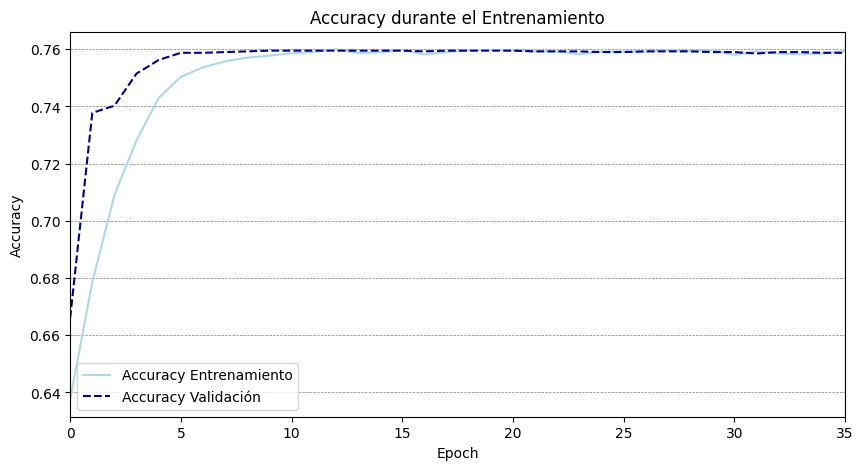

In [77]:
plt.figure(figsize=(10, 5))
plt.plot(history_cw['accuracy'], label='Accuracy Entrenamiento', color='lightblue')
plt.plot(history_cw['val_accuracy'], label='Accuracy Validación', linestyle='--', color='darkblue')
plt.title('Accuracy durante el Entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.xlim(0, 35)
plt.xticks(np.arange(0, 36, 5))
plt.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)
plt.show()

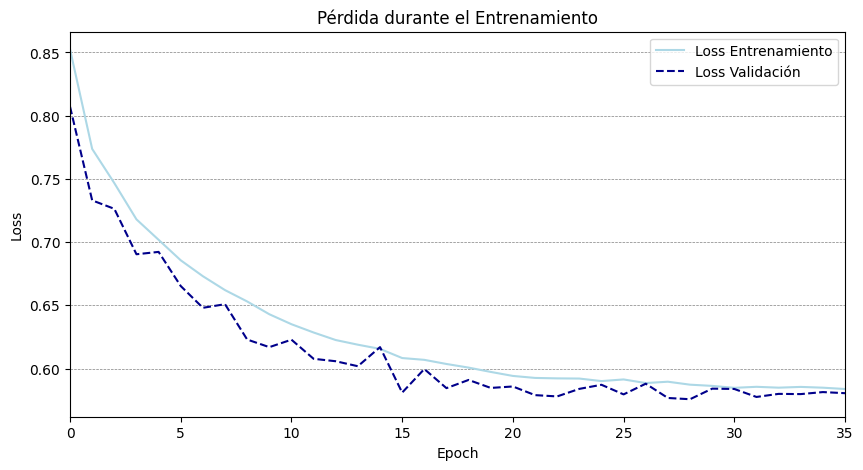

In [79]:
plt.figure(figsize=(10, 5))
plt.plot(history_cw['loss'], label='Loss Entrenamiento', color='lightblue')
plt.plot(history_cw['val_loss'], label='Loss Validación', linestyle = '--', color='darkblue')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xlim(0, 35)
plt.xticks(np.arange(0, 36, 5))
plt.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)
plt.show()

In [83]:
threshold = 0.6
y_pred_proba_final = model_cw.predict(X_test_red).ravel()
y_pred_final = (y_pred_proba_final > threshold).astype(int)

from sklearn.metrics import roc_auc_score
# --- MÉTRICAS ---
print(classification_report(y_test, y_pred_final, digits=4))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
              precision    recall  f1-score   support

           0     0.3021    0.6906    0.4203      1283
           1     0.9438    0.7652    0.8452      8717

    accuracy                         0.7556     10000
   macro avg     0.6230    0.7279    0.6327     10000
weighted avg     0.8615    0.7556    0.7907     10000



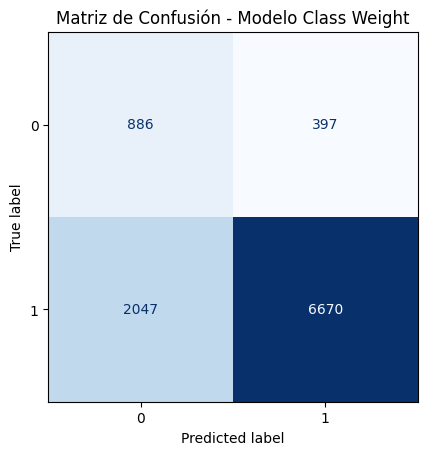

In [84]:
# --- MATRIZ DE CONFUSIÓN ---
cm_final = confusion_matrix(y_test, y_pred_final)
ConfusionMatrixDisplay(confusion_matrix=cm_final).plot(
                        values_format='d',cmap='Blues', colorbar=False
                        )

plt.title(f'Matriz de Confusión - Modelo Class Weight')
plt.grid(False)
plt.show()

### **Comparación de Modelos: Red Neuronal vs Modelos Base.**
En esta sección realizamos una evaluación comparativa entre la red neuronal entrenada (`model_cw`) y dos modelos clásicos de referencia:

- **Árboles de decisión**
- **Random Forest**
- **Regresión Logística**

El objetivo es determinar si la red neuronal realmente ofrece mejoras significativas respecto a modelos tradicionales, especialmente en un contexto de **desequilibrio de clases**, donde es crucial evaluar más allá de la `accuracy`.

**Métricas de evaluación seleccionadas:**

- **Recall de la clase 0**: Fundamental en contextos sensibles como medicina o detección de fraude, donde los falsos negativos son costosos.
- **Precision de la clase 0**
- **F1-score de la clase 0**
- **ROC-AUC**: Evaluación global del modelo, especialmente útil en datasets desbalanceados.

Adicionalmente, se incluirá una **curva ROC comparativa** para visualizar el rendimiento discriminativo de cada modelo.

> **Importante**: Todos los modelos se evalúan sobre el mismo conjunto de test y usando un umbral fijo de 0.6.

In [108]:
# Definición modelos base.
logreg = LogisticRegression(class_weight='balanced', random_state=42)
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
tree = DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth=5)

# Entrenamiento de modelos base.
logreg.fit(X_train_red, y_train)
rf.fit(X_train_red, y_train)
tree.fit(X_train_red, y_train)

# Predicción de modelos base.
y_pred_proba_log = logreg.predict_proba(X_test_red)[:, 1]
y_pred_proba_rf = rf.predict_proba(X_test_red)[:, 1]
y_pred_proba_tree = tree.predict_proba(X_test_red)[:, 1]
y_pred_proba_nn = y_pred_proba_final

In [109]:
def evaluate_model(y_true, y_proba, threshold=0.6):
    y_pred = (y_proba > threshold).astype(int)
    return {
        'Recall (0)': recall_score(y_true, y_pred, pos_label=0),
        'Precision (0)': precision_score(y_true, y_pred, pos_label=0),
        'F1-score (0)': f1_score(y_true, y_pred, pos_label=0),
        'ROC-AUC': roc_auc_score(y_true, y_proba)
    }

# --- Evaluación ---
metrics_log = evaluate_model(y_test, y_pred_proba_log)
metrics_rf = evaluate_model(y_test, y_pred_proba_rf)
metrics_nn = evaluate_model(y_test, y_pred_proba_nn)
metrics_tree = evaluate_model(y_test, y_pred_proba_tree)

In [112]:
df_comparacion = pd.DataFrame([metrics_log, metrics_rf, metrics_nn, metrics_tree],
                            index=['Logistic Regression', 'Random Forest', 'Neural Network', 'Decision Tree'])
df_comparacion

,Recall (0),Precision (0),F1-score (0),ROC-AUC
Logistic Regression,0.686672,0.307183,0.424476,0.744097
Random Forest,0.113796,0.411268,0.178266,0.733325
Neural Network,0.690569,0.302080,0.420304,0.740219
Decision Tree,0.681216,0.307314,0.423552,0.738314


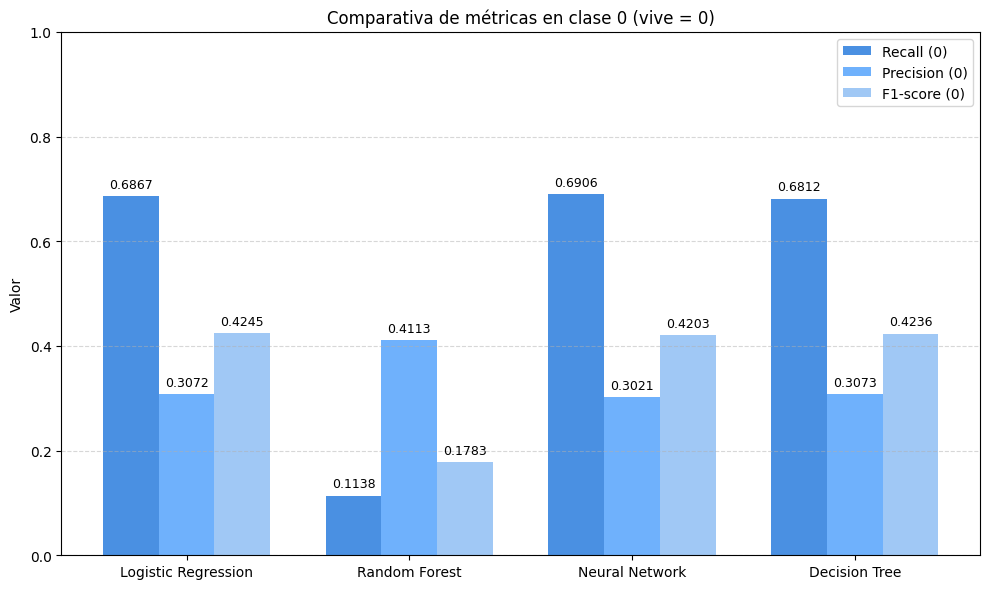

In [ ]:
metrics_to_plot = ['Recall (0)', 'Precision (0)', 'F1-score (0)']
df_plot = df_comparacion[metrics_to_plot]
model_names = df_plot.index.tolist()
x = np.arange(len(model_names))
width = 0.25

# Tonos azules para cada métrica
colors = ['#4A90E2', '#6FB1FC', '#A0C8F5']

plt.figure(figsize=(10, 6))

# Barras para cada métrica con color azul personalizado
for i, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    plt.bar(x + (i - 1) * width, df_plot[metric], width, label=metric, color=color)

# Añadir valores sobre cada barra con 4 decimales
for i, metric in enumerate(metrics_to_plot):
    for j, val in enumerate(df_plot[metric]):
        plt.text(j + (i - 1) * width, val + 0.01, f"{val:.4f}", ha='center', va='bottom', fontsize=9)

# Personalización del gráfico
plt.xticks(x, model_names, rotation=0)
plt.ylim(0, 1)
plt.ylabel('Valor')
plt.title('Comparativa de métricas en clase 0 (vive = 0)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


El gráfico muestra de forma clara el comportamiento de cada modelo en las **tres métricas clave para la clase minoritaria y crítica**: `recall`, `precision` y `f1-score`.

- **Neural Network (cw)** es el modelo más equilibrado:
    - **Máximo `recall`** (0.6906), lo que significa que **detecta la mayor cantidad de pacientes en riesgo**.
    - Aunque su `precision` es algo baja (0.3021), es **comparable a la de los demás** y compensa con un `f1-score` sólido (0.4203).

- **Logistic Regression** es muy competitivo:

    - Tiene un rendimiento muy similar al de la red neuronal, con apenas diferencias en `recall` y `f1-score`.
    - Puede ser una opción válida en entornos donde se priorice simplicidad.

- **Decision Tree** sorprende positivamente:

    - Obtiene métricas casi idénticas a la red neuronal.
    - Puede ser útil si se busca **máxima interpretabilidad**, aunque es más sensible al sobreajuste si se entrena sin regularización.

- **Random Forest** queda claramente rezagado:

    - Aunque ofrece buena `precision` (0.4113), su `recall` (0.1138) es **extremadamente bajo**, lo que lo **inhabilita para detectar correctamente pacientes en riesgo**.


> La **red neuronal con `class_weight`** ofrece el **mejor balance entre sensibilidad y precisión**, siendo la opción más robusta para este problema clínico. **El árbol de decisión destaca por su simplicidad y rendimiento competitivo**, y puede considerarse una **alternativa interpretable**. **Random Forest**, en cambio, resulta ineficaz en este contexto.

### **Interpretabilidad del modelo con SHAP.**
Aunque las redes neuronales ofrecen un rendimiento sólido en tareas de clasificación compleja, una de sus principales limitaciones es su naturaleza de **"caja negra"**, es decir, la dificultad para entender por qué toman una decisión concreta. En el contexto médico, esto **no es aceptable**, ya que la confianza en la predicción debe ir acompañada de **trazabilidad y explicación clara de los factores que influyen en la decisión**.

**SHAP (SHapley Additive exPlanations)** es una técnica de explicabilidad basada en teoría de juegos que permite estimar la **contribución individual de cada variable de entrada** al resultado del modelo. Es especialmente útil para modelos complejos como redes neuronales, ya que:

* Asigna un valor SHAP a cada feature, cuantificando su **impacto en la predicción**.
* Permite identificar **qué variables aumentan o disminuyen la probabilidad de supervivencia** (`vive = 1`).
* Proporciona visualizaciones intuitivas y adaptadas para un entorno clínico o analítico.

**¿Cómo lo aplicaremos aquí?**
1. Utilizaremos el modelo final seleccionado (`Neural Network con class_weight`) ya entrenado.
2. Aplicaremos `shap.KernelExplainer` sobre un subconjunto del test set para estimar las contribuciones.
3. Mostraremos:

   * Un **summary plot** (resumen global de importancia de variables).
   * Opcional: **dependence plots** para variables clave (cómo afecta un valor específico al output del modelo).

> Con este análisis, **el objetivo es entender no solo qué tan bien predice el modelo, sino también cómo lo hace**, lo cual es crucial en aplicaciones médicas donde se necesita transparencia y respaldo clínico.

In [128]:
print('Columnas seleccionadas:')
print(top_features)

Columnas seleccionadas:
['cancer', 'gastos_salud', 'glucosa', 'leucocitos', 'trigliceridos', 'colesterol', 'enfermedad_cardiaca', 'hemoglobina', 'plaquetas', 'ingresos_mensuales', 'creatinina', 'edad', 'nivel_educativo', 'sexo', 'actividad_fisica']


Para facilitar una interpretación más clara y significativa de los resultados de SHAP, organizaremos las variables en **grupos temáticos** según su naturaleza clínica, demográfica o económica.

Esta estrategia tiene múltiples beneficios:

- **Reduce la sobrecarga visual** en los gráficos SHAP
- **Permite enfocar la atención** en bloques de variables relacionados
- **Favorece la narrativa explicativa** (“primero lo clínico, luego lo económico...”)

Agrupar las variables no solo mejora la presentación, sino que **acerca el análisis a la lógica interpretativa de expertos médicos o de negocio**.

A continuación, exploraremos el impacto de los grupos de variables sobre las predicciones del modelo, comenzando por los **biomarcadores clínicos**.

In [139]:
X_test_df = X_test_red.copy()

In [ ]:
# Reducimos para hacerlo más rápido.
X_sample = shap.sample(X_test_df, 100, random_state=42)
X_eval = X_test_df.iloc[:50]

# Aseguramos que la salida del modelo sea 1D
predict_fn = lambda x: model_cw.predict(x).reshape(-1)

# Explicador
explainer = shap.KernelExplainer(predict_fn, X_sample)

# Cálculo de SHAP values
shap_values = explainer.shap_values(X_eval)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


  2%|▏         | 1/50 [00:11<09:16, 11.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


  4%|▍         | 2/50 [00:26<10:56, 13.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


  6%|▌         | 3/50 [00:37<09:37, 12.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


  8%|▊         | 4/50 [00:48<09:02, 11.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 10%|█         | 5/50 [01:00<08:52, 11.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 12%|█▏        | 6/50 [01:14<09:19, 12.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 14%|█▍        | 7/50 [01:26<09:00, 12.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 16%|█▌        | 8/50 [01:38<08:36, 12.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 18%|█▊        | 9/50 [01:48<07:47, 11.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 20%|██        | 10/50 [01:58<07:19, 11.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 22%|██▏       | 11/50 [02:08<06:58, 10.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 24%|██▍       | 12/50 [02:18<06:42, 10.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 26%|██▌       | 13/50 [02:28<06:25, 10.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 28%|██▊       | 14/50 [02:38<06:08, 10.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 30%|███       | 15/50 [02:47<05:49,  9.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 32%|███▏      | 16/50 [02:57<05:36,  9.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 34%|███▍      | 17/50 [03:07<05:28,  9.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 36%|███▌      | 18/50 [03:17<05:21, 10.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 38%|███▊      | 19/50 [03:28<05:13, 10.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 40%|████      | 20/50 [03:37<04:55,  9.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 42%|████▏     | 21/50 [03:47<04:48,  9.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 44%|████▍     | 22/50 [04:01<05:08, 11.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 46%|████▌     | 23/50 [04:14<05:14, 11.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 48%|████▊     | 24/50 [04:25<04:57, 11.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 50%|█████     | 25/50 [04:38<05:00, 12.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 52%|█████▏    | 26/50 [04:50<04:49, 12.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 54%|█████▍    | 27/50 [05:01<04:32, 11.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 56%|█████▌    | 28/50 [05:13<04:20, 11.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 58%|█████▊    | 29/50 [05:26<04:11, 11.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 60%|██████    | 30/50 [05:37<03:53, 11.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 62%|██████▏   | 31/50 [05:47<03:37, 11.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 64%|██████▍   | 32/50 [06:01<03:36, 12.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 66%|██████▌   | 33/50 [06:12<03:21, 11.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 68%|██████▊   | 34/50 [06:33<03:53, 14.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 70%|███████   | 35/50 [06:44<03:22, 13.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 72%|███████▏  | 36/50 [06:56<03:01, 12.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 74%|███████▍  | 37/50 [07:09<02:49, 13.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 76%|███████▌  | 38/50 [07:21<02:32, 12.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 78%|███████▊  | 39/50 [07:33<02:15, 12.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 80%|████████  | 40/50 [07:46<02:07, 12.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 82%|████████▏ | 41/50 [08:00<01:57, 13.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 84%|████████▍ | 42/50 [08:10<01:38, 12.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 86%|████████▌ | 43/50 [08:20<01:19, 11.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 88%|████████▊ | 44/50 [08:29<01:05, 10.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 90%|█████████ | 45/50 [08:39<00:52, 10.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 92%|█████████▏| 46/50 [08:48<00:40, 10.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 94%|█████████▍| 47/50 [08:57<00:29,  9.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 96%|█████████▌| 48/50 [09:07<00:19,  9.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 98%|█████████▊| 49/50 [09:16<00:09,  9.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


100%|██████████| 50/50 [09:25<00:00, 11.30s/it]


In [154]:
# Grupo 1: Biomarcadores / Variables clínicas.
biomarcadores = [
    'glucosa', 'leucocitos', 'trigliceridos', 'colesterol',
    'hemoglobina', 'plaquetas', 'creatinina'
]

# Grupo 2: Condiciones médicas diagnosticadas.
enfermedades = [
    'cancer', 'enfermedad_cardiaca'
]

# Grupo 3: Datos sociodemográficos y estilo de vida.
sociodemograficas = [
    'edad', 'sexo', 'nivel_educativo', 'actividad_fisica'
]

# Grupo 4: Factores económicos.
economicas = [
    'gastos_salud', 'ingresos_mensuales'
]

In [155]:
# Convertimos los shap_values en DataFrame con el mismo orden de columnas que X_eval.
shap_df = pd.DataFrame(shap_values, columns=X_eval.columns)

**Interpretación general del gráfico SHAP** El eje **X** representa el impacto de cada variable sobre la predicción del modelo (valores SHAP).
- Valores **positivos** empujan hacia la **supervivencia** (`vive = 1`).
- Valores **negativos** empujan hacia la **no supervivencia** (`vive = 0`).
- El color indica si el valor de la variable era **alto (rojo)** o **bajo (azul)** para cada paciente.

#### **Biomarcadores / Variables clínicas (sanguíneas o fisiológicas).**

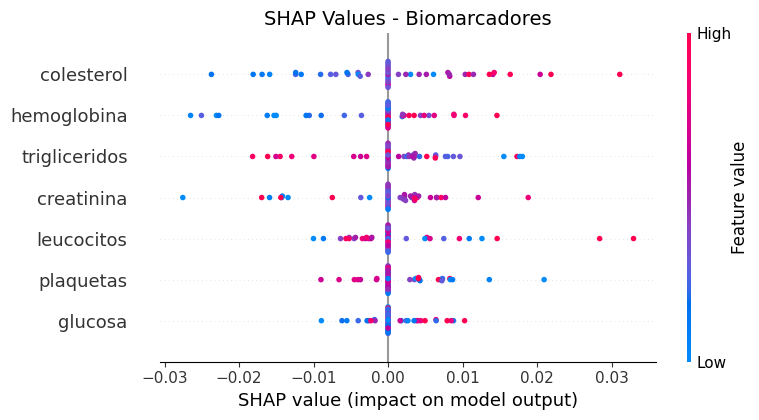

In [ ]:
# Biomarcadores.
shap.summary_plot(shap_df[biomarcadores].values, X_eval[biomarcadores], show=False)
plt.title('SHAP Values - Biomarcadores', fontsize=14)
plt.tight_layout()
plt.show()

Este gráfico muestra cómo diferentes **valores clínicos extraídos de análisis sanguíneos** influyen en la predicción de supervivencia realizada por el modelo neuronal (`class_weight`). Se analizan las siguientes variables: `colesterol`, `hemoglobina`, `triglicéridos`, `creatinina`, `leucocitos`, `plaquetas` y `glucosa`.
1. **Colesterol:** Valores altos (rojo) tienden a tener **impacto positivo** en la predicción de supervivencia. Esto podría indicar que, en esta muestra, el colesterol **no está asociado directamente con peor pronóstico**, o incluso que niveles muy bajos (azul) podrían relacionarse con casos clínicamente más graves.

2. **Hemoglobina:** Los valores **más altos** se concentran en la zona positiva del SHAP. **Mayor hemoglobina** podría asociarse a **mejor oxigenación y mejor estado general**, aumentando la probabilidad de supervivencia.

3. **Triglicéridos:** Efecto mixto pero estable: valores altos tienen un leve empuje hacia la **supervivencia**. Posible relación con el estado nutricional general del paciente.

4. **Creatinina:** Valores altos (rojos) se asocian levemente con **peor pronóstico**, aunque el efecto es suave. Esto tiene sentido clínico, ya que la creatinina elevada suele indicar **daño renal**, un factor de riesgo importante.

5. **Leucocitos:** No hay un patrón fuerte, pero algunos valores bajos (azules) aparecen hacia la zona negativa. Puede indicar que **sistemas inmunitarios debilitados** (pocos leucocitos) empeoran el pronóstico.

6. **Plaquetas:** Distribución bastante neutra, con efecto débil sobre la predicción global.

7. **Glucosa:** También muestra **efecto mixto**, pero con cierto sesgo hacia la parte negativa.Esto puede indicar que niveles muy altos de glucosa (rojo) se asocian a **mayor riesgo de complicaciones** o a estados de salud más comprometidos.

> El modelo reconoce correctamente el **peso clínico de varios biomarcadores conocidos**, como la hemoglobina, la creatinina o la glucosa, para estimar la probabilidad de supervivencia. Este tipo de interpretabilidad permite al personal médico **verificar que el modelo no toma decisiones arbitrarias**, sino que **responde de forma coherente a marcadores médicos objetivos**.

#### **Enfermedades.**

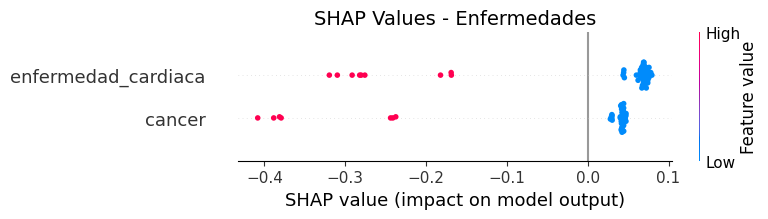

In [161]:
shap.summary_plot(shap_df[enfermedades].values, X_eval[enfermedades], show=False)
plt.title('SHAP Values - Enfermedades', fontsize=14)
plt.tight_layout()
plt.show()

En este gráfico se visualiza el impacto que tienen dos variables binarizadas (`0`: no tiene la enfermedad, `1`: la tiene) sobre la predicción de supervivencia (`vive = 1`) del modelo neuronal.

1. **Enfermedad cardíaca:** Todos los puntos rojos están fuertemente asociados a valores SHAP negativos (hasta -0.4). Esto significa que **tener enfermedad cardíaca disminuye significativamente la probabilidad de supervivencia** según el modelo. Es una conclusión médicamente coherente, ya que las enfermedades cardiovasculares son un factor de riesgo importante en casi cualquier cuadro clínico.

2. **Cáncer:** También muestra una clara tendencia: los pacientes con cáncer (rojo) tienen valores SHAP negativos. Aunque el impacto es **menos extremo que el de enfermedad cardíaca**, sigue contribuyendo negativamente a la predicción de supervivencia.

> El modelo ha aprendido a **asociar correctamente la presencia de enfermedades graves como el cáncer o la patología cardíaca con un mayor riesgo de no supervivencia**, lo cual **valida su capacidad para reconocer patrones clínicos reales y críticos**.

Este tipo de visualización permite que los profesionales médicos **confíen en el modelo como herramienta de apoyo**: no solo predice bien, sino que **lo hace con fundamentos clínicamente explicables**.

#### **Sociodemográficas.**

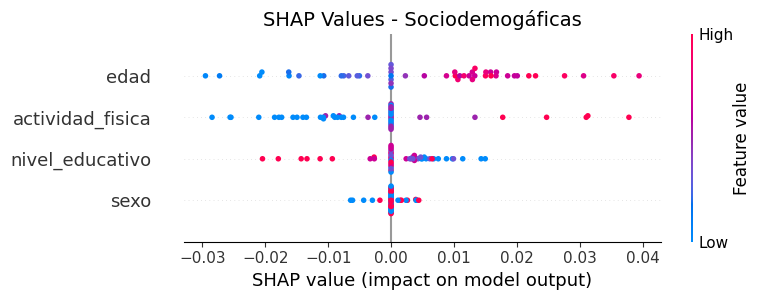

In [162]:
shap.summary_plot(shap_df[sociodemograficas].values, X_eval[sociodemograficas], show=False)
plt.title('SHAP Values - Sociodemogáficas', fontsize=14)
plt.tight_layout()
plt.show()

El gráfico muestra cómo influyen factores personales como la **edad**, la **actividad física**, el **nivel educativo** y el **sexo** en la predicción del modelo neuronal sobre si un paciente sobrevivirá.

1. **Edad:** Claramente estructurada: los valores altos de edad (rojo) están a la derecha. Contraintuitivo, pero **el modelo interpreta edad avanzada como ligeramente protectora**. Posible interpretación:
    - Puede que haya más datos de personas mayores que han sobrevivido.
    - O que el modelo esté captando **edad como proxy de estabilidad crónica controlada**, más que de fragilidad.

2. **Actividad física:** Los valores altos (rojo) están a la derecha ⇒ aumentan la probabilidad de supervivencia. Coherente: mayor actividad física = mejor estado general.

3. **Nivel educativo:** Efecto leve, pero los valores bajos (azul) se distribuyen hacia SHAP negativos. Sugerencia: **mayor educación podría correlacionarse con mejor salud general y acceso a cuidados**, lo que aumenta la supervivencia.

4. **Sexo:** Distribución neutra y simétrica. No parece tener un impacto fuerte. El modelo no considera el sexo como una variable determinante en este caso.

> El modelo neuronal reconoce que **la actividad física y el nivel educativo tienen un papel positivo en la supervivencia**, mientras que el efecto de la edad puede depender del perfil del paciente. La variable sexo, en cambio, **no parece discriminativa** en este caso. Esta información es útil para contextualizar las predicciones desde un enfoque biopsicosocial.

#### **Económicas.**

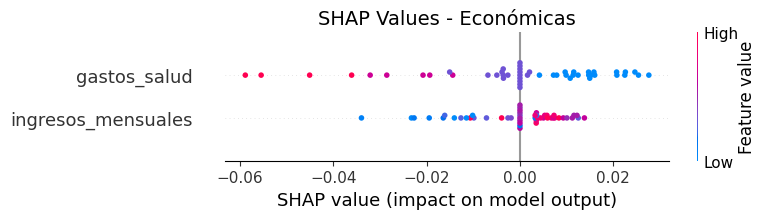

In [163]:
shap.summary_plot(shap_df[economicas].values, X_eval[economicas], show=False)
plt.title('SHAP Values - Económicas', fontsize=14)
plt.tight_layout()
plt.show()

Este gráfico evalúa el efecto de dos variables que representan el **entorno económico del paciente**:
- `gastos_salud`: gasto mensual estimado en salud.
- `ingresos_mensuales`: ingresos personales o familiares.

Ambas variables reflejan **acceso a recursos**, lo cual puede influir en la supervivencia.

1. **Gastos en salud:** Los valores altos (rojo) se asocian a valores SHAP negativos. Indica que **mayores gastos en salud predicen menor probabilidad de supervivencia**. Coherente: puede representar **enfermedades graves o tratamientos intensivos**, no necesariamente mejor acceso.

2. **Ingresos mensuales:** Los valores bajos (azul) están en la zona negativa, mientras que los más altos (rojo) tienden a ser neutros o positivos. Sugiere que **tener mayores ingresos puede mejorar el pronóstico**, aunque el impacto es limitado. Esto refleja que **el nivel económico podría proteger parcialmente**, posiblemente por mayor acceso a cuidados o condiciones de vida saludables.

> El modelo aprende que **un mayor gasto en salud suele indicar mayor gravedad o vulnerabilidad clínica**, reduciendo la probabilidad de supervivencia. En cambio, **tener mayores ingresos podría asociarse a una mayor estabilidad y acceso a cuidados**, aunque su impacto es más moderado. Estos hallazgos respaldan la necesidad de **interpretar variables económicas con cuidado**, ya que no siempre reflejan directamente el nivel de salud.